In [171]:
import numpy as np
from names_dataset import NameDataset
from nn import Layer, MLP
import matplotlib.pyplot as plt
import torch.nn.functional as F
from utils import draw_dot
import pandas as pd
import torch

In [172]:
df = pd.read_csv('data.csv', header=None)
first_col = df.iloc[:, 0]
first_col = first_col.str.lower()
first_col = first_col.to_list()
names = first_col

In [173]:
class Node:
    def __init__(self, data, _children=(), label='', _op=''):
        self.data = data
        self.grad = 0.0
        self.label = label
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data + other.data, (self, other), _op="+")

        def _backward():
            if self.data.ndim > other.data.ndim:  # self is a matrix, other is a vector (bias)
                self.grad += out.grad
                other.grad += out.grad.sum(axis=0)
            elif other.data.ndim > self.data.ndim:  # other is a matrix, self is a vector (bias)
                self.grad += out.grad.sum(axis=0)
                other.grad += out.grad
            else:  # Both are of the same dimensions
                self.grad += out.grad
                other.grad += out.grad

        out._backward = _backward
        return out
    
    def sum(self, axis=None, keepdims=False):
        out = Node(np.sum(self.data, axis=axis, keepdims=keepdims), (self,), _op="SUM")

        def _backward():
            self.grad += out.grad * np.ones_like(self.data)
        
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1
    
    def __radd__(self, other):
        return self + other
    
    def __rtruediv__(self, other):
        return other * self**-1

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
    
    def __rmul__(self, other):
        return self * other
    
    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data*other.data, (self, other), _op="*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        
        out._backward = _backward
        return out
    
    def std(self, axis=None, keepdims=False):
        out = Node(np.std(self.data, axis=axis, keepdims=keepdims), (self,), _op="STD")

        def _backward():
            self.grad += out.grad * np.ones_like(self.data) / self.data.size

        out._backward = _backward
        return out

    def mean(self, axis=None, keepdims=False):
        out = Node(np.mean(self.data, axis=axis, keepdims=keepdims), (self,), _op="MEAN")

        def _backward():
            self.grad += out.grad * np.ones_like(self.data) / self.data.size
        
        out._backward = _backward
        return out
    
    def reshape(self, out_shape):
        out = Node(self.data.reshape(-1, out_shape), (self,), _op="RESHAPE")

        def _backward():
            self.grad += np.reshape(out.grad, self.data.shape)

        out._backward = _backward
        return out
    
    def single_index_select(self, indices):
        indices = np.asarray(indices)
        selected_data = self.data[indices]
        
        out = Node(selected_data, (self,), _op="SINGLE_INDEX_SELECT")

        def _backward():
            grad = np.zeros_like(self.data)
            np.add.at(grad, indices, out.grad)
            self.grad += grad

        out._backward = _backward
        return out
    
    def __len__(self):
        return len(self.data)
    
    def abs(self):
        out = Node(np.abs(self.data), (self,), _op="ABS")

        def _backward():
            self.grad += out.grad * np.sign(self.data)
        
        out._backward = _backward
        return out

    def max(self, axis=None, keepdims=False):
        out = Node(np.max(self.data, axis=axis, keepdims=keepdims), (self,), _op="MAX")

        def _backward():
            self.grad += out.grad * (self.data == out.data)
        
        out._backward = _backward
        return out
    
    def index_select(self, row_indices, col_indices):
        row_indices = np.asarray(row_indices)
        col_indices = np.asarray(col_indices)

        selected_data = self.data[row_indices, col_indices]
        out = Node(selected_data, (self,), _op="INDEX_SELECT")

        def _backward():
            grad = np.zeros_like(self.data)
            np.add.at(grad, (row_indices, col_indices), out.grad)
            self.grad += grad
        
        out._backward = _backward
        return out

    def __truediv__(self, other, eps=1e-9):
        other = other if isinstance(other, Node) else Node(float(other))
        return self * other**-1
        #adjusted_other = other + eps
        #return self * adjusted_other**-1
    
    def __pow__(self, other):
        out = Node(self.data**other, (self,), _op="**")

        def _backward():
            self.grad += (other * self.data ** (other- 1))*out.grad
        
        out._backward = _backward
        return out
    
    def dot(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(np.dot(self.data, other.data), (self, other), _op="DOT")

        def _backward():
            self.grad += np.dot(out.grad, other.data.T)
            other.grad += np.dot(self.data.T, out.grad)
        
        out._backward = _backward
        return out
    
    def exp(self):
        out = Node(np.exp(self.data), (self,), _op="EXP")

        def _backward():
            self.grad += out.grad * np.exp(self.data)
        
        out._backward = _backward
        return out

    def log(self, eps=1e-9):
        out = Node(np.log(self.data + eps), (self,), _op="LOG")

        def _backward():
            self.grad += out.grad * (1 / (self.data+1e-10))
        
        out._backward = _backward
        return out
    
    def relu(self):
        out = Node(np.maximum(self.data, 0), (self,), _op="RELU")

        def _backward():
            self.grad += out.grad if self.data > 0 else 0
        
        out._backward = _backward
        return out
    
    def tanh(self):
        out = Node(np.tanh(self.data), (self,), _op="TANH")

        def _backward():
            self.grad += out.grad * (1 - np.tanh(self.data)**2)
        
        out._backward = _backward
        return out
    
    def relu(self):
        out = Node(np.maximum(self.data, 0), (self,), _op="RELU")

        def _backward():
            self.grad += out.grad if self.data > 0 else 0
        
        out._backward = _backward
        return out
    
    def shape(self):
        return self.data.shape
    
    def backward(self, clip_value=5):
        # topological order all of the children in the graph
        topo = []
        visited = []
        def build_topo(v):
            if v not in visited:
                visited.append(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and applb the chain rule to get its gradient
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()
            #if isinstance(v.grad, np.ndarray):
            #    np.clip(v.grad, -clip_value, clip_value, out=v.grad)
            
    def __repr__(self):
        return f"Node(data={self.data})"

In [174]:
unique_chars = set()
for name in names:
    unique_chars.update(set(name.lower()))
    if ' ' in name:
        print(name)
        names.remove(name)
        unique_chars.remove(' ')


unique_chars = sorted(list(unique_chars))
print(len(names))
print(len(unique_chars))
print(unique_chars)

S_to_I = {s:i+1 for i,s in enumerate(unique_chars)}
S_to_I['.'] = 0
I_to_S = {s:i for i,s in S_to_I.items()}

print(S_to_I)
print(I_to_S)

6782
26
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [180]:
def build_dataset(words, numpy=True, block_size = 4): 
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = S_to_I[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] 

    if numpy:
        X = np.array(X)
        Y = np.array(Y)
    else:
        X = torch.tensor(X)
        Y = torch.tensor(Y)

    return X, Y

In [181]:
"""
if i % 101 == 0:
        ax[0].hist(hpreact.data.ravel(), bins=100)
        ax[0].set_title('hpreact')
        ax[1].hist(h.data.ravel(), bins=100)
        ax[1].set_title('h')
        ax[2].hist(logits.data.ravel(), bins=100)
        ax[2].set_title('logits')
        ax[3].hist(prob.data.ravel(), bins=100)
        ax[3].set_title('prob')
        break
#How many of h are > 0.99
    bigger_ = len(np.where(h.data.reshape(-1,1) > 0.999)[0])/(h.data.reshape(-1,1).shape[0])
    smaller_ = len(np.where(h.data.reshape(-1,1) < -0.999)[0])/(h.data.reshape(-1,1).shape[0])
    bigger_plus_smaller = bigger_ + smaller_
    print(f"Values of 98 or -98: {bigger_plus_smaller*100}%")
"""

'\nif i % 101 == 0:\n        ax[0].hist(hpreact.data.ravel(), bins=100)\n        ax[0].set_title(\'hpreact\')\n        ax[1].hist(h.data.ravel(), bins=100)\n        ax[1].set_title(\'h\')\n        ax[2].hist(logits.data.ravel(), bins=100)\n        ax[2].set_title(\'logits\')\n        ax[3].hist(prob.data.ravel(), bins=100)\n        ax[3].set_title(\'prob\')\n        break\n#How many of h are > 0.99\n    bigger_ = len(np.where(h.data.reshape(-1,1) > 0.999)[0])/(h.data.reshape(-1,1).shape[0])\n    smaller_ = len(np.where(h.data.reshape(-1,1) < -0.999)[0])/(h.data.reshape(-1,1).shape[0])\n    bigger_plus_smaller = bigger_ + smaller_\n    print(f"Values of 98 or -98: {bigger_plus_smaller*100}%")\n'

In [240]:
BLOCKSIZE = 5
INPUT_SIZE = 10
HIDDEN = 100

X, Y = build_dataset(names, numpy=True, block_size=BLOCKSIZE)

print(f"Number of names = {len(names)}")
C = Node(np.random.randn(27, INPUT_SIZE))
W1 = Node(np.random.randn(INPUT_SIZE*BLOCKSIZE, HIDDEN))*0.01#(5/3)/(np.sqrt(10*block_size))
b1 = Node(np.random.randn(HIDDEN))*0
W2 = Node(np.random.randn(HIDDEN,27))*0.01
b2 = Node(np.random.randn(27))*0
gamma = Node(np.ones((1,HIDDEN), dtype=W1.data.dtype))
beta = Node(np.zeros((1,HIDDEN), dtype=W1.data.dtype))
BATCH_SIZE = 32
params = {'C': C, 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'gamma': gamma, 'beta': beta}
nbr_params = sum(p.data.size for p in params.values())
print(f'number of parameters = {nbr_params}')

Number of names = 6782
number of parameters = 8297


INIT Loss: 3.243366504676203
Loss: 3.243366504676203
Loss: 3.1454124282781355
Loss: 3.186863869790664
Loss: 3.1872265289367543
Loss: 3.1059284643770706
Loss: 3.215061949836495
Loss: 3.026094343577342
Loss: 3.00196014717208
Loss: 3.1029080145477614
Loss: 3.168634598530165
Final loss: 2.954278104035397


Text(0.5, 1.0, 'Loss avg')

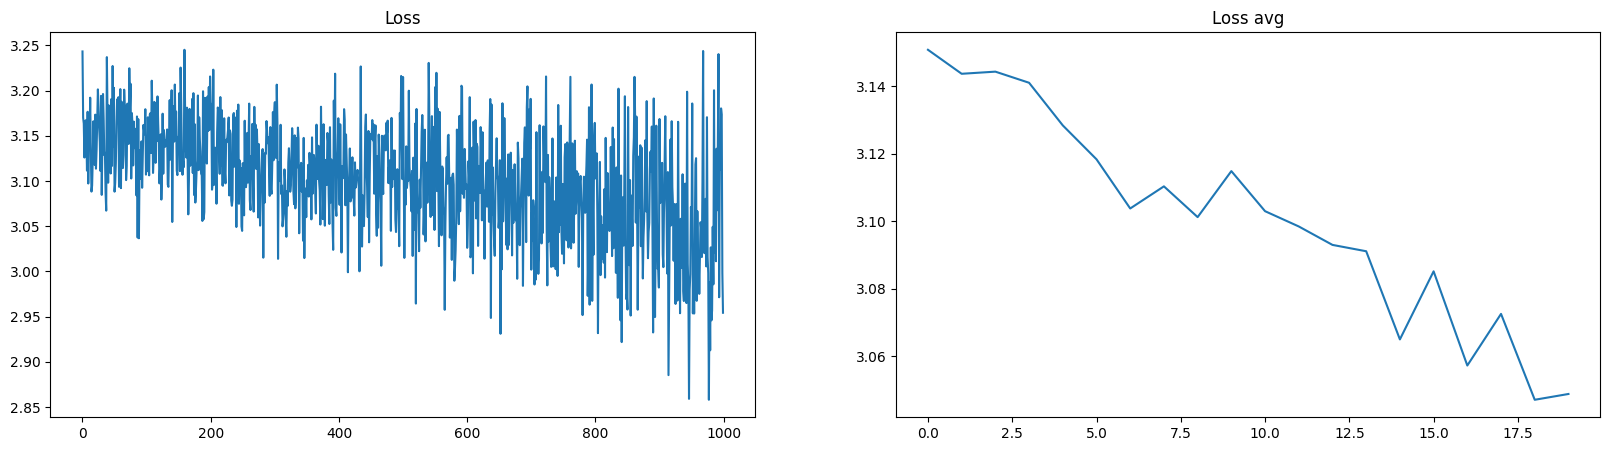

In [242]:
#TRAIN:
loses = []
for i in range(1000):
    
    # minibatch construct
    ix = np.random.randint(0, X.shape[0], size=BATCH_SIZE)

    #Forward pass
    emb = C.single_index_select(X[ix])
    hpreact = emb.reshape(INPUT_SIZE*BLOCKSIZE).dot(W1) + b1
    hpreact = (hpreact - hpreact.mean(axis=0, keepdims=True)) / hpreact.std(axis=0, keepdims=True) 
    hpreact = gamma * hpreact + beta
    h = hpreact.tanh()
    logits = h.dot(W2) + b2
    logits_max = logits.max(axis=1, keepdims=True)
    logits = logits - logits_max
    prob = logits.exp() / logits.exp().sum(axis=1, keepdims=True)
    loss = -prob.index_select((np.arange(len(X[ix]))), Y[ix]).log().mean()
    if i == 0:
        print(f"INIT Loss: {loss.data}")
   
    #Backward pass
    for p in params.values():
        p.grad = 0.0
    loss.backward()
   
    #Update
    lr = 0.001
    for k,v in params.items():
        if k == 'gamma' or k == 'beta':
            v.data -= lr * v.grad.mean(axis=0)
        else:
            v.data -= lr * v.grad

    loses.append(loss.data)
    if i % 100 == 0:
        print(f"Loss: {loss.data}")

        
    
print(f"Final loss: {loss.data}")
losses = np.array(loses)
losses = losses.reshape(-1,50).mean(axis=1)
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax = ax.ravel()
ax[0].plot(loses)
ax[0].set_title("Loss")
ax[1].plot(losses)
ax[1].set_title("Loss avg")

In [243]:
X,Y = build_dataset(names, numpy=False, block_size=BLOCKSIZE)


g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, INPUT_SIZE), generator=g)
W1 = torch.randn((INPUT_SIZE*BLOCKSIZE, HIDDEN), generator=g)*(5/3)/(np.sqrt(INPUT_SIZE*BLOCKSIZE))
b1 = torch.randn(HIDDEN, generator=g)*0
W2 = torch.randn((HIDDEN, 27), generator=g)*0.01
b2 = torch.randn(27, generator=g)*0
gamma = torch.ones((1,HIDDEN))
beta = torch.zeros((1,HIDDEN))

print(f"Kaiming: {(5/3)/(np.sqrt(INPUT_SIZE*BLOCKSIZE))}")

parameters = [C, W1, b1, W2, b2, gamma, beta]

print(f"Params: {sum(p.nelement() for p in parameters)}")
for p in parameters:
  p.requires_grad = True

loses = []

Kaiming: 0.23570226039551584
Params: 8297


In [250]:
BATCH_SIZE = 32
ITERATIONS = 1000
LR = 0.01

for i in range(ITERATIONS):
  
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (BATCH_SIZE,))
  
  # forward pass
  emb = C[X[ix]]
  hpreact = emb.view(-1, BLOCKSIZE*INPUT_SIZE) @ W1 + b1
  hpreact = gamma*(hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)+beta
  h = torch.tanh(hpreact) 
  logits = h @ W2 + b2 #
  counts = logits.exp()
  prob = counts / counts.sum(dim=1, keepdim=True)
  #loss = -prob[torch.arange(len(X[ix])), Y[ix]].log().mean()
  loss = F.cross_entropy(logits, Y[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  for p in parameters:
    p.data += -LR * p.grad

  #if i % 100 == 0:
  #  print(f"Loss: {loss.item()}")
  
  loses.append(loss.item())

print(f"Final loss: {loss.item()}")

Final loss: 2.4907617568969727


Text(0.5, 1.0, 'Loss diff')

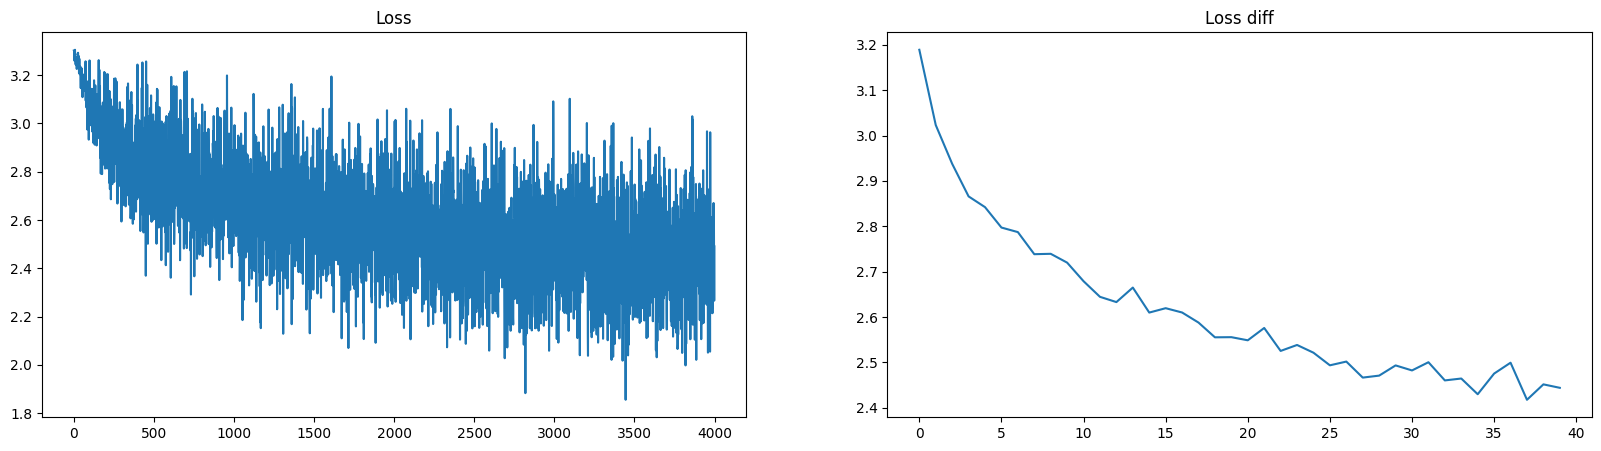

In [251]:
losses = np.array(loses)
losses = losses.reshape(-1,100).mean(axis=1)
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax = ax.ravel()
ax[0].plot(loses)
ax[0].set_title("Loss")
ax[1].plot(losses)
ax[1].set_title("Loss diff")